In [60]:
import numpy as np
import pandas as pd
pd.set_option('display.precision', 3)
import json
import os
import glob
from statsmodels.stats.proportion import proportion_confint
import matplotlib
import matplotlib.pyplot as plt
import sys
import argparse


In [61]:
zero_gen_probs = ['succ', 'pred', 'add_letter', 'remove_redundant', 'fix_alphabet', 'sort', 'attn']
one_gen_probs = ["larger_int", "longer_targ", "group", "interleaved", "letter2num", "reverse"]
two_gen_probs = ["2gen_split1", "2gen_split2", "2gen_split3", "2gen_split4", "2gen_split5", "2gen_split6", "2gensplit7"]
three_gen_probs = ["3gen_split1", "3gen_split2", "3gen_split3", "3gen_split4", "3gen_split5", "3gen_split6", "3gensplit7"]

In [62]:
# Loads human generalization responses and applies minimal preprocessing
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

prob_dict = dict()

human_df_gen = pd.read_csv('../results_csvs/human_gen.csv')
human_df_gen = human_df_gen.fillna('')

for i in perms:
    if i =='symb':
        npz = np.load(f'../problems/gpt_human_alphs/all_prob_{i}_14_gpt_human_alphs.npz', allow_pickle=True)
    else:
        npz = np.load(f'../problems/gpt_human_alphs/all_prob_{i}_7_gpt_human_alphs.npz', allow_pickle=True)

    prob_dict[f'np_{i}'] = npz['all_prob'].item()

source_1 = []
source_2 = []
target_1 = []
correct_answer = []
given_answer = []
correct = []
for nperms, alph, prob_type, prob_ind, response_string in zip(human_df_gen['nperms'], human_df_gen['alph'], human_df_gen['prob_type'], human_df_gen['prob_ind'], human_df_gen['response_string']):
    incorrect = False
    # get the problem and split into source and target
    # skip attention problems
    if prob_type == 'attn':
        source_1.append(['a', 'a', 'a', 'a'])
        source_2.append(['a', 'a', 'a', 'a'])
        target_1.append(['a', 'a', 'a', 'a'])
    else:
        prob = prob_dict[nperms][alph][prob_type]['prob'][int(prob_ind)]
        source_1.append(prob[0][0])
        source_2.append(prob[0][1])
        target_1.append(prob[1][0])
    # set the 'correct' answer to the problem
    if prob_type == 'attn':
        correct_answer.append(['a', 'a', 'a', 'a'])
    else:
        c_ans = prob[1][1]
        c_ans = [str(a) for a in c_ans]
        # since there are some human answers that are strings of 2 digit numbers with no spaces,
        # we form a string of the correct answer with no spaces.
        c_ans_string = ''.join(c_ans)
        correct_answer.append(c_ans_string)
    
    ans = response_string.strip(' []').split()
    given_answer.append(''.join(ans))

    # check if answer is correct
    if len(correct_answer[-1]) != len(given_answer[-1]):
        incorrect = 1
    else:
        incorrect = sum([a!=b for a, b in zip(correct_answer[-1], given_answer[-1])])
    c = not incorrect
    correct.append(c)

human_df_gen['source_1'] = source_1
human_df_gen['source_2'] = source_2
human_df_gen['target_1'] = target_1
human_df_gen['correct_answer'] = correct_answer
human_df_gen['given_answer'] = given_answer
human_df_gen['correct'] = correct
human_df_gen['total'] = 1

# calculate top level accuracy, not including performance on attention checks
df_slice = human_df_gen[human_df_gen['prob_type'] != 'attn']
overall_accuracy = sum(df_slice.correct)/len(df_slice)
errs = proportion_confint(sum(df_slice.correct), len(df_slice))
print(f"Overall human accuracy is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

Overall human accuracy is: 0.324, confidence intervals 0.304, 0.344


In [63]:
# Loads one-gen human responses and applies minimal preprocessing
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

prob_dict = dict()

human_df = pd.read_csv('../results_csvs/human_nogen.csv')
human_df = human_df.fillna('')

for i in perms:
    npz = np.load(f'../problems/human/all_prob_{i}_7_human.npz', allow_pickle=True)
    prob_dict[f'np_{i}'] = npz['all_prob'].item()

source_1 = []
source_2 = []
target_1 = []
correct_answer = []
given_answer = []
correct = []
for nperms, alph, prob_type, prob_ind, response_string in zip(human_df['nperms'], human_df['alph'], human_df['prob_type'], human_df['prob_ind'], human_df['response_string']):
    incorrect = False
    # get the problem and split into source and target
    # skip attention problems
    if prob_type == 'attn':
        source_1.append(['a', 'a', 'a', 'a'])
        source_2.append(['a', 'a', 'a', 'a'])
        target_1.append(['a', 'a', 'a', 'a'])
    else:
        prob = prob_dict[nperms][alph][prob_type]['prob'][int(prob_ind)]
        source_1.append(prob[0][0])
        source_2.append(prob[0][1])
        target_1.append(prob[1][0])
    # set the 'correct' answer to the problem
    if prob_type == 'attn':
        correct_answer.append(['a', 'a', 'a', 'a'])
    else:
        c_ans = prob[1][1]
        c_ans = [int(a) if isinstance(a, str) and a.isnumeric() else a for a in c_ans]
        correct_answer.append(c_ans)
    
    ans = response_string.strip(' []').split()
    if ans[0].isnumeric():
        given_answer.append([int(a) if a.isnumeric() else a for a in ans])
    else:
        given_answer.append([l for a in ans for l in a])

    # check if answer is correct
    if len(correct_answer[-1]) != len(given_answer[-1]):
        incorrect = 1
    else:
        incorrect = sum([a!=b for a, b in zip(correct_answer[-1], given_answer[-1])])
    c = not incorrect
    correct.append(c)

human_df['source_1'] = source_1
human_df['source_2'] = source_2
human_df['target_1'] = target_1
human_df['correct_answer'] = correct_answer
human_df['given_answer'] = given_answer
human_df['correct'] = correct
human_df['total'] = 1

# calculate top level accuracy, not including performance on attention checks
df_slice = human_df[human_df['prob_type'] != 'attn']
overall_accuracy = sum(df_slice.correct)/len(df_slice)
errs = proportion_confint(sum(df_slice.correct), len(df_slice))
print(f"Overall human accuracy is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

df_slice = human_df[(human_df['prob_type'] != 'attn')&(human_df['nperms']=='np_1')]
overall_accuracy = sum(df_slice.correct)/len(df_slice)
errs = proportion_confint(sum(df_slice.correct), len(df_slice))
print(f"Overall human accuracy unpermuted is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")
print(f'Num samples is {len(df_slice)}')

Overall human accuracy is: 0.754, confidence intervals 0.734, 0.773
Overall human accuracy unpermuted is: 0.822, confidence intervals 0.777, 0.868
Num samples is 276


In [64]:
# Get GPT data on generalized problems and put into dataframe
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']
prob_types = ['larger_int', 'longer_targ', 'group', 'interleaved', 'letter2num', 'reverse', \
                '2gen_split1', '2gen_split2', '2gen_split3', '2gen_split4', '2gen_split5', '2gen_split6',\
                '3gen_split1', '3gen_split2', '3gen_split3', '3gen_split4', '3gen_split5', '3gen_split6',]
one_gen = ['larger_int', 'longer_targ', 'group', 'interleaved', 'letter2num', 'reverse']
two_gen = ['2gen_split1', '2gen_split2', '2gen_split3', '2gen_split4', '2gen_split5', '2gen_split6',]
three_gen = ['3gen_split1', '3gen_split2', '3gen_split3', '3gen_split4', '3gen_split5', '3gen_split6']

gpt_dict = dict()
response_dict = dict()
prob_dict = dict()
data = []
count = 0
for gpt in models:
    gpt_dict[gpt] = dict()
    for promptstyle in promptstyles:
        gpt_dict[gpt][promptstyle] = dict()
        for i in perms:
            # webb promptstyle only valid for unpermuted
            if promptstyle in ['webb', 'webbplus'] and i != 1:
                continue
            # skipping certain cases for symb alphabet 
            if i == 'symb' and (gpt not in ['35', '4'] or promptstyle != 'hw'):
                print(gpt + ' not in list')
                continue
            elif i == 'symb' and gpt in ['35', '4'] and promptstyle == 'hw':
                print(gpt + ' in list')
                try:
                    # special case for later symb results
                    prob_npz = np.load(f'../problems/gpt_human_alphs/all_prob_{i}_14_gpt_human_alphs.npz', allow_pickle=True)
                    prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()
                    gpt_npz = np.load(f'../GPT{gpt}_prob_predictions_multi_alph/gen/gpt{gpt}_letterstring_results_{i}_gen_multi_alph_gptprobs_azure_{promptstyle}.npz', allow_pickle=True)
                    gpt_dict[gpt][promptstyle][f'np_{i}'] = gpt_npz['all_prob_type_responses'].item()   
                except:
                    print(f'../problems/gpt_human_alphs/all_prob_{i}_14_gpt_human_alphs.npz') 
                    print(f'../GPT{gpt}_prob_predictions_multi_alph/gen/gpt{gpt}_letterstring_results_{i}_gen_multi_alph_gptprobs_azure_{promptstyle}.npz')
            else:  
                prob_npz = np.load(f'../problems/gpt_human_alphs/all_prob_{i}_{num_alphs}_gpt_human_alphs.npz', allow_pickle=True)
                prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()
                gpt_npz = np.load(f'../GPT{gpt}_prob_predictions_multi_alph/gen/gpt{gpt}_letterstring_results_{i}_multi_alph_gptprobs_{promptstyle}.npz', allow_pickle=True)
                gpt_dict[gpt][promptstyle][f'np_{i}'] = gpt_npz['all_prob_type_responses'].item()
            for k, alph in enumerate(prob_dict[f'np_{i}'].keys()):
                if k > 6:
                    continue
                current_prob_types = list(prob_dict[f'np_{i}'][alph].keys())
                current_prob_types.remove('shuffled_letters')
                current_prob_types.remove('shuffled_alphabet')
                for j, prob_type in enumerate(current_prob_types):
                        if len(prob_dict[f'np_{i}'][alph][prob_type]['prob']) != len(gpt_dict[gpt][promptstyle][f'np_{i}'][alph][j]):
                            print(len(prob_dict[f'np_{i}'][alph][prob_type]['prob']), len(gpt_dict[gpt][promptstyle][f'np_{i}'][alph][j]))
                            break
                        for prob_ind in range(len(prob_dict[f'np_{i}'][alph][prob_type]['prob'])):
                            prob = prob_dict[f'np_{i}'][alph][prob_type]['prob'][int(prob_ind)]
                            source = prob[0]
                            target = prob[1]
                            if prob_type == 'attn':
                                correct_answer = ['a', 'a', 'a', 'a']
                            else:
                                correct_answer = [int(a) if isinstance(a, str) and a.isnumeric() else a for a in prob[1][1]]

                            gpt_response = gpt_dict[gpt][promptstyle][f'np_{i}'][alph][j][prob_ind]
                            first_bracket = gpt_response.find(']')
                            if first_bracket != -1:
                                gpt_response = gpt_response[:first_bracket]
                            gpt_response = gpt_response.strip(' []').split()
                            if len(gpt_response) > 0 and gpt_response[0].isnumeric():
                                given_answer = [int(a) if a.isnumeric() else a for a in gpt_response ]
                            else:
                                given_answer = [l for a in gpt_response for l in a]
                            if len(correct_answer) != len(given_answer):
                                incorrect = 1
                            else:
                                incorrect = sum([a!=b for a, b in zip(correct_answer, given_answer)])
                            correct = not incorrect

                            total = 1
                            if promptstyle =='human':
                                data.append([f'gpt_{gpt}', gpt, 'human-like', f'np_{i}', alph, prob_type, prob_ind, source[0], source[1], target[0], correct_answer, given_answer, correct, total])
                            else:
                                data.append([f'gpt_{gpt}', gpt, promptstyle, f'np_{i}', alph, prob_type, prob_ind, source[0], source[1], target[0], correct_answer, given_answer, correct, total])
                 
                                

gpt_gen_df = pd.DataFrame(data, columns=['subj_id', 'model', 'promptstyle', 'nperms', 'alph', 'prob_type','prob_ind', 'source_1', 'source_2', 'target_1', 'correct_answer', 'given_answer', 'correct', 'total'])

promptstyles = [ 'human-like', 'minimal', 'hw']
for n in ['3', '35', '4']:
    for promptstyle in promptstyles:
        df_slice = gpt_gen_df[(gpt_gen_df['model']==n)&(gpt_gen_df['promptstyle']==promptstyle)&(gpt_gen_df['prob_type']!='attn')]
        overall_accuracy = sum(df_slice.correct)/len(df_slice)
        errs = proportion_confint(sum(df_slice.correct), len(df_slice))
        print(f"Overall accuracy for gpt {n}, promptstyle {promptstyle} is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

promptstyles = ['hw']
for n in ['3', '35', '4']:
    for promptstyle in promptstyles:
        df_slice = gpt_gen_df[(gpt_gen_df['model']==n)&(gpt_gen_df['promptstyle']==promptstyle)&(gpt_gen_df['prob_type']!='attn')&(gpt_gen_df['nperms']=='np_1')]
        overall_accuracy = sum(df_slice.correct)/len(df_slice)
        errs = proportion_confint(sum(df_slice.correct), len(df_slice))
        print(f"Overall accuracy unpermuted for gpt {n}, promptstyle {promptstyle} is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

3 not in list
3 not in list
3 not in list
35 not in list
35 not in list
35 in list
4 not in list
4 not in list
4 in list
Overall accuracy for gpt 3, promptstyle human-like is: 0.000, confidence intervals 0.000, 0.000
Overall accuracy for gpt 3, promptstyle minimal is: 0.203, confidence intervals 0.193, 0.212
Overall accuracy for gpt 3, promptstyle hw is: 0.224, confidence intervals 0.214, 0.234
Overall accuracy for gpt 35, promptstyle human-like is: 0.023, confidence intervals 0.019, 0.027
Overall accuracy for gpt 35, promptstyle minimal is: 0.109, confidence intervals 0.102, 0.116
Overall accuracy for gpt 35, promptstyle hw is: 0.127, confidence intervals 0.120, 0.135
Overall accuracy for gpt 4, promptstyle human-like is: 0.227, confidence intervals 0.217, 0.237
Overall accuracy for gpt 4, promptstyle minimal is: 0.219, confidence intervals 0.209, 0.228
Overall accuracy for gpt 4, promptstyle hw is: 0.217, confidence intervals 0.208, 0.226
Overall accuracy unpermuted for gpt 3, prompt

In [65]:
# Get GPT one-gen data and put into dataframe
num_alphs = 7
perms = [1, 2, 5, 10, 20, 'symb']
models = ['3', '35', '4']
promptstyles = ['human', 'minimal', 'hw', 'webb', 'webbplus']
promptstyles = ['human', 'minimal', 'hw', 'webb']
nperms = [f'np_{i}' for i in perms]
alphs = [f'alph_{j}' for j in range(num_alphs)]
prob_types = ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']

gpt_dict = dict()
response_dict = dict()
prob_dict = dict()
data = []
count = 0
for gpt in models:
    gpt_dict[gpt] = dict()
    for promptstyle in promptstyles:
        gpt_dict[gpt][promptstyle] = dict()
        for i in perms:
            if promptstyle in ['webb', 'webbplus'] and i != 1:
                continue
            prob_npz = np.load(f'../problems/human/all_prob_{i}_{num_alphs}_human.npz', allow_pickle=True)
            prob_dict[f'np_{i}'] = prob_npz['all_prob'].item()
            gpt_npz = np.load(f'../GPT{gpt}_prob_predictions_multi_alph/nogen/gpt{gpt}_letterstring_results_{i}_multi_alph_{promptstyle}.npz', allow_pickle=True)
            gpt_dict[gpt][promptstyle][f'np_{i}'] = gpt_npz['all_prob_type_responses'].item()
            for k, alph in enumerate(prob_dict[f'np_{i}'].keys()):
                if k > 6:
                    continue
                current_prob_types = list(prob_dict[f'np_{i}'][alph].keys())
                current_prob_types.remove('shuffled_letters')
                current_prob_types.remove('shuffled_alphabet')
                for j, prob_type in enumerate(current_prob_types):
                        for prob_ind in range(len(prob_dict[f'np_{i}'][alph][prob_type]['prob'])):
                            prob = prob_dict[f'np_{i}'][alph][prob_type]['prob'][int(prob_ind)]
                            source = prob[0]
                            target = prob[1]
                            if prob_type == 'attn':
                                # print(rs)
                                correct_answer = ['a', 'a', 'a', 'a']
                            else:
                                correct_answer = prob[1][1]

                            gpt_response = gpt_dict[gpt][promptstyle][f'np_{i}'][alph][j][prob_ind]
                            first_bracket = gpt_response.find(']')
                            if first_bracket != -1:
                                gpt_response = gpt_response[:first_bracket]
                            given_answer = [a for a in list(gpt_response) if a not in ' []']
                            if len(correct_answer) != len(given_answer):
                                incorrect = 1
                            else:
                                incorrect = sum([a!=b for a, b in zip(correct_answer, given_answer)])
                            correct = not incorrect

                            total = 1
                            if promptstyle =='human':
                                data.append([f'gpt_{gpt}', gpt, 'human-like', f'np_{i}', alph, prob_type, prob_ind, source[0], source[1], target[0], correct_answer, given_answer, correct, total])
                            else:
                                data.append([f'gpt_{gpt}', gpt, promptstyle, f'np_{i}', alph, prob_type, prob_ind, source[0], source[1], target[0], correct_answer, given_answer, correct, total])
                                

gpt_df = pd.DataFrame(data, columns=['subj_id','model', 'promptstyle', 'nperms', 'alph', 'prob_type', 'prob_ind','source_1', 'source_2', 'target_1', 'correct_answer', 'given_answer', 'correct', 'total'])

promptstyles = [ 'human-like', 'minimal', 'hw']
for n in ['3', '35', '4']:
    for promptstyle in promptstyles:
        df_slice = gpt_df[(gpt_df['model']==n)&(gpt_df['promptstyle']==promptstyle)&(gpt_df['prob_type']!='attn')]
        overall_accuracy = sum(df_slice.correct)/len(df_slice)
        errs = proportion_confint(sum(df_slice.correct), len(df_slice))
        print(f"Overall accuracy for gpt {n}, promptstyle {promptstyle} is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")

promptstyles = ['hw']
for n in ['3', '35', '4']:
    for promptstyle in promptstyles:
        df_slice = gpt_df[(gpt_df['model']==n)&(gpt_df['promptstyle']==promptstyle)&(gpt_df['prob_type']!='attn')&(gpt_df['nperms']=='np_1')]
        overall_accuracy = sum(df_slice.correct)/len(df_slice)
        errs = proportion_confint(sum(df_slice.correct), len(df_slice))
        print(f"Overall accuracy  unpermuted for gpt {n}, promptstyle {promptstyle} is: {overall_accuracy:.3f}, confidence intervals {errs[0]:.3f}, {errs[1]:.3f}")
        print(f'Num samples is {len(df_slice)}')

Overall accuracy for gpt 3, promptstyle human-like is: 0.000, confidence intervals 0.000, 0.000
Overall accuracy for gpt 3, promptstyle minimal is: 0.491, confidence intervals 0.470, 0.512
Overall accuracy for gpt 3, promptstyle hw is: 0.488, confidence intervals 0.467, 0.509
Overall accuracy for gpt 35, promptstyle human-like is: 0.093, confidence intervals 0.081, 0.105
Overall accuracy for gpt 35, promptstyle minimal is: 0.293, confidence intervals 0.273, 0.312
Overall accuracy for gpt 35, promptstyle hw is: 0.350, confidence intervals 0.330, 0.370
Overall accuracy for gpt 4, promptstyle human-like is: 0.455, confidence intervals 0.434, 0.476
Overall accuracy for gpt 4, promptstyle minimal is: 0.436, confidence intervals 0.415, 0.457
Overall accuracy for gpt 4, promptstyle hw is: 0.452, confidence intervals 0.431, 0.473
Overall accuracy  unpermuted for gpt 3, promptstyle hw is: 0.621, confidence intervals 0.575, 0.668
Num samples is 420
Overall accuracy  unpermuted for gpt 35, prompt

In [66]:
# concatenate human and gpt data, add column for number of generalizations and save to csv

full_df = pd.concat([human_df, human_df_gen, gpt_df, gpt_gen_df])

num_gens = []

for pt in full_df['prob_type']:
    if pt in ['succ', 'pred', 'add_letter', 'remove_redundant','fix_alphabet', 'sort', 'attn']:
        num_gens.append(0)
    elif pt in one_gen_probs:
        num_gens.append(1)
    elif pt in two_gen_probs:
        num_gens.append(2)
    elif pt in three_gen_probs:
        num_gens.append(3)
    else:
        print(pt)

assert len(num_gens)==len(full_df)

full_df['num_gens'] = num_gens

full_df.to_csv('../results_csvs/gpt_human_data.csv', index=False)

In [67]:
# Set up the choices for models, number of permutations, prompt styles, and categorizing prbolems by number of generalizations

models = ['human', '3', '35', '4']
nperms = [f'np_{i}' for i in [1, 2, 5, 10, 20, 'symb']]
promptstyles = ['human', 'human-like', 'webb', 'minimal', 'hw']
zero_gen_probs = ['succ', 'pred', 'add_letter', 'remove_redundant', 'fix_alphabet', 'sort', 'attn']
one_gen_probs = ["larger_int", "longer_targ", "group", "interleaved", "letter2num", "reverse"]
two_gen_probs = ["2gen_split1", "2gen_split2", "2gen_split3", "2gen_split4", "2gen_split5", "2gen_split6"]
three_gen_probs = ["3gen_split1", "3gen_split2", "3gen_split3", "3gen_split4", "3gen_split5", "3gen_split6"]

In [68]:
# Load WHL original data
webb_orig = np.load('../webb_original/all_gen_acc.npz')
accs = webb_orig['all_acc']
errs = webb_orig['all_err']
print(accs)

[0.71333333 0.50333333 0.35666667 0.24333333]


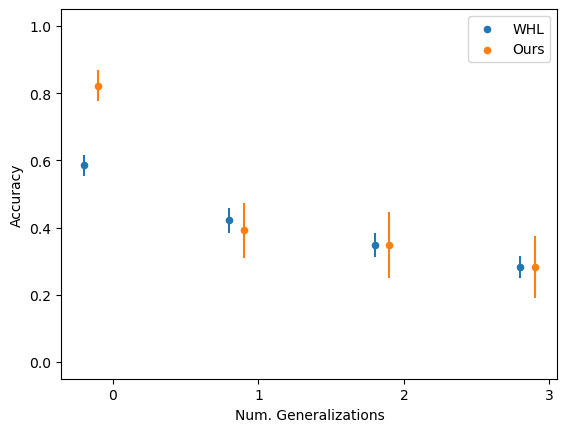

In [69]:
# plot human results by Webb only

gen_df = full_df[(full_df.promptstyle=='human')&(full_df.prob_type!='attn')&(full_df.model=='human')&(full_df.nperms=='np_1')]
gen_df = gen_df.groupby(['model', 'promptstyle', 'num_gens'], as_index=False).sum()
gen_df = gen_df.drop(columns='prob_ind')

gen_df['acc'] = gen_df['correct']/gen_df['total']
gen_df['cilow'] = proportion_confint(gen_df['correct'], gen_df['total'])[0]
gen_df['ciupp'] = proportion_confint(gen_df['correct'], gen_df['total'])[1]
gen_df['yerr_low'] = gen_df['acc']-gen_df['cilow']
gen_df['yerr_upp'] = gen_df['ciupp']-gen_df['acc']

gen_df['model'] = pd.Categorical(gen_df['model'], ordered = True, categories = models)
gen_df['promptstyle'] = pd.Categorical(gen_df['promptstyle'], ordered = True, categories = promptstyles)
gen_df['num_gens'] = pd.Categorical(gen_df['num_gens'], ordered = True, categories = [0, 1, 2, 3])
gen_df = gen_df.sort_values(['model', 'promptstyle', 'num_gens'])

fig, ax = plt.subplots()

webb_orig = np.load('../webb_original/all_gen_acc_human.npz')
accs = webb_orig['all_acc']
errs = webb_orig['all_err']

scat = ax.scatter(np.arange(len(accs)), accs, s=20)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)), accs,  yerr=errs, ls='none', color=scat.get_facecolors()[-1])

ax.set_ylabel("Accuracy")
df_slice = gen_df[(gen_df['model']=='human')]

# get the accuracies
accs = df_slice.acc

# get the upper and lower errors
yerr_low = list(df_slice['yerr_low'])
yerr_upp = list(df_slice['yerr_upp'])
# plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
scat = ax.scatter(np.arange(len(accs)) + 0.1, accs, s=20)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)) + 0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
# put the legend on the last plot 
# put the xtick labels, offset by 0.2 to put them in the centre of each group of points
ax.set_xticks(np.arange(len(accs))+0.2)
ax.set_xticklabels(list(range(4)))
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Num. Generalizations')
ax.legend(['WHL', 'Ours'])
plt.savefig('../plotting/num_gens_webb_human.pdf', bbox_inches='tight')

Total samples for model 3
  num_gens  total
0        0    420
1        1    420
2        2    490
3        3    490
Total samples for model 35
  num_gens  total
4        0    420
5        1    420
6        2    490
7        3    490
Total samples for model 4
   num_gens  total
8         0    420
9         1    420
10        2    490
11        3    490


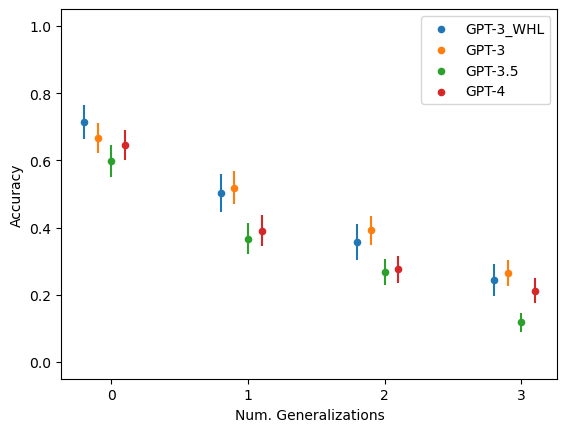

In [70]:
# plot GPT results by Webb only

gen_df = full_df[(full_df.promptstyle=='webb')&(full_df.prob_type!='attn')&(full_df.nperms=='np_1')]
gen_df = gen_df.groupby(['model', 'promptstyle', 'num_gens'], as_index=False).sum()
gen_df = gen_df.drop(columns='prob_ind')

gen_df['acc'] = gen_df['correct']/gen_df['total']
gen_df['cilow'] = proportion_confint(gen_df['correct'], gen_df['total'])[0]
gen_df['ciupp'] = proportion_confint(gen_df['correct'], gen_df['total'])[1]
gen_df['yerr_low'] = gen_df['acc']-gen_df['cilow']
gen_df['yerr_upp'] = gen_df['ciupp']-gen_df['acc']

gen_df['model'] = pd.Categorical(gen_df['model'], ordered = True, categories = models)
gen_df['promptstyle'] = pd.Categorical(gen_df['promptstyle'], ordered = True, categories = promptstyles)

gen_df['num_gens'] = pd.Categorical(gen_df['num_gens'], ordered = True, categories = [0, 1, 2, 3])
gen_df = gen_df.sort_values(['model', 'promptstyle', 'num_gens'])

fig, ax = plt.subplots()

webb_orig = np.load('../webb_original/all_gen_acc_gpt.npz')
accs = webb_orig['all_acc']
errs = webb_orig['all_err']

scat = ax.scatter(np.arange(len(accs)), accs, s=20)
# plot the error bars, offset by the same increment, using the same facecolors
ax.errorbar(np.arange(len(accs)), accs,  yerr=errs, ls='none', color=scat.get_facecolors()[-1])

for i, model in enumerate(['3', '35', '4']):
    ax.set_ylabel("Accuracy")
    df_slice = gen_df[(gen_df['model']==model)]
    # print(df_slice)
    # get the accuracies
    accs = df_slice.acc
    print(f'Total samples for model {model}')
    print(df_slice[['num_gens', 'total']])
    # get the upper and lower errors
    yerr_low = list(df_slice['yerr_low'])
    yerr_upp = list(df_slice['yerr_upp'])
    # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
    scat = ax.scatter(np.arange(len(accs)) + (i+1)*0.1, accs, s=20)
    # plot the error bars, offset by the same increment, using the same facecolors
    ax.errorbar(np.arange(len(accs)) + (i+1)*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    # put the legend on the last plot 
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    ax.set_xticks(np.arange(len(accs))+0.2)
    # ax.set_xticklabels(['Succ', 'Pred', 'Add', 'Rem', 'Fix', 'Sort'])
    ax.set_xticklabels(list(range(4)))
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Num. Generalizations')
ax.legend(['GPT-3_WHL','GPT-3', 'GPT-3.5', 'GPT-4'])
plt.savefig('num_gens_webb.pdf', bbox_inches='tight')

In [71]:
# Get accuracy by number of generalizations.
nperms = [f'np_{i}' for i in [1, 2, 5, 10, 20, 'symb']]
grouped_df = full_df[(full_df.prob_type!='attn')]
grouped_df = grouped_df[~(grouped_df.num_gens.isin([2, 3])&(grouped_df.nperms=='np_symb'))]
grouped_df = grouped_df.groupby(['model', 'promptstyle', 'num_gens'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
grouped_df['num_gens'] = pd.Categorical(grouped_df['num_gens'], ordered = True, categories = [0, 1, 2, 3])
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'num_gens'])

grouped_df = grouped_df[(grouped_df.promptstyle=='human')|(grouped_df.promptstyle=='hw')]

for i in range(4):
    df_slice = grouped_df[grouped_df.num_gens==i]
    print(df_slice[['model', 'num_gens','acc', 'cilow','ciupp']])

    model num_gens    acc  cilow  ciupp
48  human        0  0.754  0.734  0.773
4       3        0  0.488  0.467  0.509
20     35        0  0.350  0.330  0.370
36      4        0  0.452  0.431  0.473
    model num_gens    acc  cilow  ciupp
49  human        1  0.358  0.329  0.387
5       3        1  0.333  0.313  0.353
21     35        1  0.175  0.161  0.190
37      4        1  0.271  0.253  0.288
    model num_gens    acc  cilow  ciupp
50  human        2  0.317  0.277  0.358
6       3        2  0.194  0.179  0.210
22     35        2  0.131  0.117  0.144
38      4        2  0.219  0.202  0.235
    model num_gens    acc  cilow  ciupp
51  human        3  0.260  0.222  0.298
7       3        3  0.160  0.145  0.174
23     35        3  0.078  0.067  0.088
39      4        3  0.195  0.179  0.210


num_gens 0, model human
      nperms  total
203     np_1    276
207    np_10    342
211     np_2    336
215    np_20    384
219     np_5    270
223  np_symb    268
num_gens 0, model 3
     nperms  total
21     np_1    420
25    np_10    420
29     np_2    420
33    np_20    420
37     np_5    420
41  np_symb     40
num_gens 0, model 35
      nperms  total
88      np_1    420
92     np_10    420
96      np_2    420
100    np_20    420
104     np_5    420
108  np_symb     40
num_gens 0, model 4
      nperms  total
156     np_1    420
160    np_10    420
164     np_2    420
168    np_20    420
172     np_5    420
176  np_symb     40
num_gens 1, model human
      nperms  total
204     np_1    138
208    np_10    153
212     np_2    156
216    np_20    150
220     np_5    159
224  np_symb    306
num_gens 1, model 3
   nperms  total
22   np_1    420
26  np_10    420
30   np_2    420
34  np_20    420
38   np_5    420
num_gens 1, model 35
      nperms  total
89      np_1    420
93     np_10   

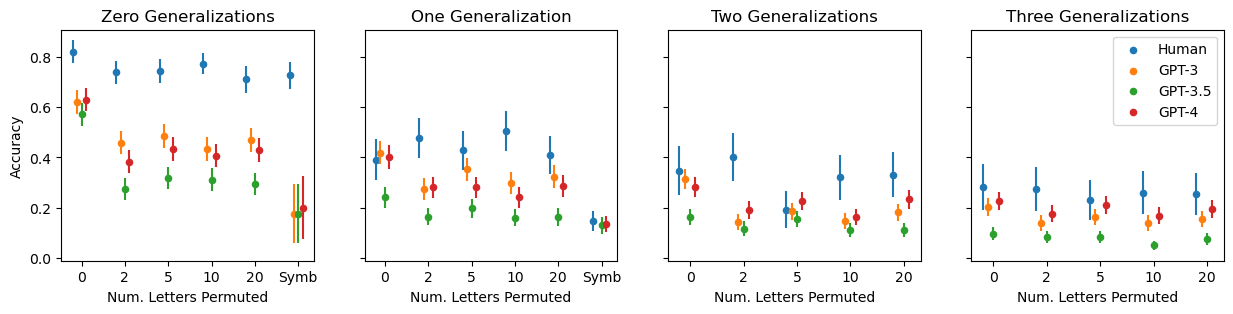

In [72]:
# Plot generalized performance by num. letters permuted
nperms = [f'np_{i}' for i in [1, 2, 5, 10, 20, 'symb']]
grouped_df = full_df[(full_df.prob_type!='attn')]
grouped_df = grouped_df[(grouped_df.nperms!='np_symb')|(grouped_df.num_gens).isin([0, 1])]
grouped_df = grouped_df.groupby(['model', 'promptstyle', 'nperms', 'num_gens'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
# grouped_df['prob_type'] = pd.Categorical(grouped_df['prob_type'], ordered = True, categories = prob_types)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df['num_gens'] = pd.Categorical(grouped_df['num_gens'], ordered = True, categories = [0, 1, 2, 3])
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'num_gens'])


fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))

axs[0].set_ylabel("Accuracy")
grouped_df = grouped_df[(grouped_df.promptstyle=='human')|(grouped_df.promptstyle=='hw')]
# print(df_slice)
for i in range(4):
    df_slice = grouped_df[grouped_df.num_gens==i]
    for j, model in enumerate(models):
        # get the accuracies
        accs = df_slice[df_slice.model == model]['acc']
        print(f'num_gens {i}, model {model}')
        print(df_slice[df_slice.model == model][['nperms', 'total']])
        # get the upper and lower errors
        yerr_low = list(df_slice [df_slice.model == model]['yerr_low'])
        yerr_upp = list(df_slice [df_slice.model == model]['yerr_upp'])
        # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
        scat = axs[i].scatter(np.arange(len(accs)) + j*0.1, accs, s=20)
        # plot the error bars, offset by the same increment, using the same facecolors
        axs[i].errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
        # put the legend on the last plot
        # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
        if i < 2:
            axs[i].set_xticks(np.arange(6)+0.2)
            axs[i].set_xticklabels([0, 2, 5, 10, 20, 'Symb'])
        else:
            axs[i].set_xticks(np.arange(5)+0.2)
            axs[i].set_xticklabels([0, 2, 5, 10, 20])
        axs[i].set_xlabel('Num. Letters Permuted')
        ax.set_ylim([0, 1])
axs[0].set_title('Zero Generalizations')
axs[1].set_title('One Generalization')
axs[2].set_title('Two Generalizations')
axs[3].set_title('Three Generalizations')
axs[-1].legend(['Human', 'GPT-3', 'GPT-3.5', 'GPT-4']) 
plt.savefig('gpt_human_gen.pdf', bbox_inches='tight')

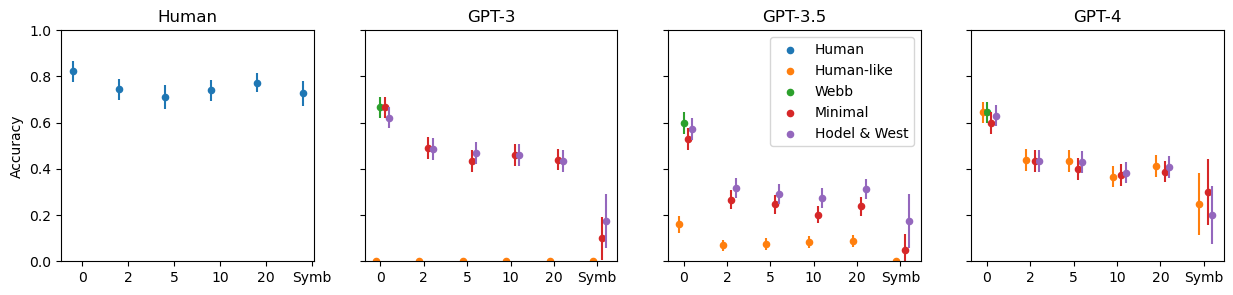

In [73]:
# Plot performance for one-gen problems by model and promptstyle
nperms = [f'np_{i}' for i in [1, 2, 5, 10, 20, 'symb']]
grouped_df = full_df[(full_df.prob_type!='attn')&(full_df.num_gens==0)]
grouped_df = grouped_df.groupby(['model', 'promptstyle', 'nperms'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')


grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
# grouped_df['prob_type'] = pd.Categorical(grouped_df['prob_type'], ordered = True, categories = prob_types)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'nperms'])


fig, axs = plt.subplots(nrows = 1, ncols=len(models), sharey=True, figsize=(15,3))

titles = ['Human', 'GPT-3', 'GPT-3.5', 'GPT-4']

for i, model in enumerate(models):
    axs[i].set_title(titles[i])
    if i == 0:
        axs[i].set_ylabel("Accuracy")
    df_slice = grouped_df[(grouped_df['model']==model)]
    # print(df_slice)
    for j, promptstyle in enumerate(promptstyles):
        # get the accuracies
        accs = df_slice[df_slice.promptstyle == promptstyle]['acc']
        # get the upper and lower errors
        yerr_low = list(df_slice [df_slice.promptstyle == promptstyle]['yerr_low'])
        yerr_upp = list(df_slice [df_slice.promptstyle == promptstyle]['yerr_upp'])
        # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
        scat = axs[i].scatter(np.arange(len(accs)) + j*0.1, accs, s=20)
        # plot the error bars, offset by the same increment, using the same facecolors
        axs[i].errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
        # put the legend on the last plot
        if i == 2:
            axs[i].legend(['Human', 'Human-like', 'Webb', 'Minimal', 'Hodel & West']) 
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    axs[i].set_xticks(np.arange(len(nperms))+0.2)
    axs[i].set_xticklabels([0, 2, 5, 10, 20, 'Symb'])
    axs[i].set_ylim([0, 1])
plt.savefig('gpt_all_promptstyles.pdf', bbox_inches='tight')

['succ', 'pred', 'add_letter', 'remove_redundant', 'fix_alphabet', 'sort', 'attn']


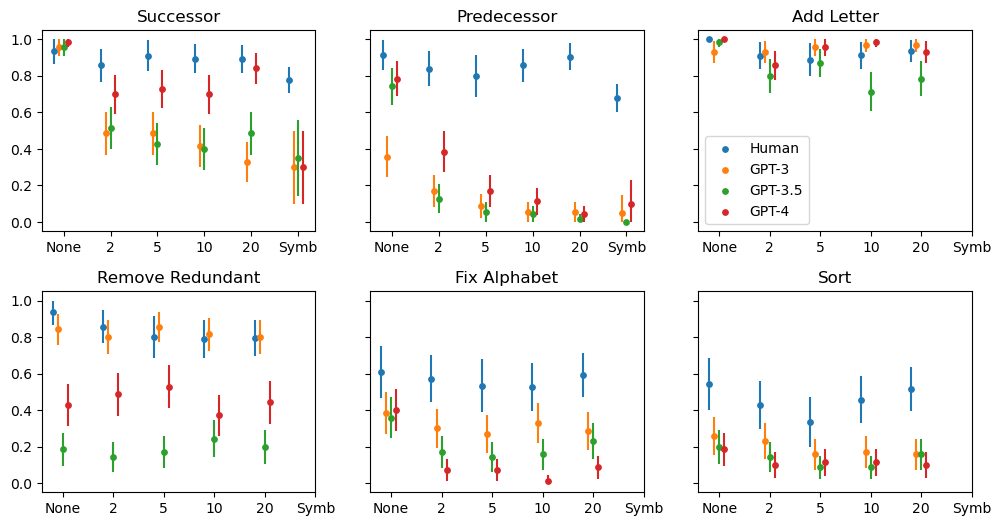

In [80]:
## plot zerogen data by problem type and num perms
grouped_df = full_df[(full_df.prob_type!='attn')&(full_df.num_gens==0)]
grouped_df = grouped_df.groupby(['model', 'promptstyle', 'nperms', 'prob_type'], as_index=False).sum()
grouped_df = grouped_df.drop(columns='prob_ind')

grouped_df['acc'] = grouped_df['correct']/grouped_df['total']
grouped_df['cilow'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[0]
grouped_df['ciupp'] = proportion_confint(grouped_df['correct'], grouped_df['total'])[1]
grouped_df['yerr_low'] = grouped_df['acc']-grouped_df['cilow']
grouped_df['yerr_upp'] = grouped_df['ciupp']-grouped_df['acc']

grouped_df['model'] = pd.Categorical(grouped_df['model'], ordered = True, categories = models)
grouped_df['promptstyle'] = pd.Categorical(grouped_df['promptstyle'], ordered = True, categories = promptstyles)
grouped_df['prob_type'] = pd.Categorical(grouped_df['prob_type'], ordered = True, categories = prob_types)
grouped_df['nperms'] = pd.Categorical(grouped_df['nperms'], ordered = True, categories = nperms)
grouped_df = grouped_df.sort_values(['model', 'promptstyle', 'prob_type', 'nperms'])
                         
fig, axs = plt.subplots(nrows = 2, ncols=3, sharey=True, figsize=(12,6))

df_slice = grouped_df[(grouped_df.promptstyle == 'hw') | (grouped_df.promptstyle == 'human')]
print(prob_types)
titles = ['Successor', 'Predecessor', 'Add Letter', 'Remove Redundant', 'Fix Alphabet', 'Sort', 'Attention']

# plot performance by problem type
for i, prob_type in enumerate(prob_types[:-1]):
    if i < 3:
        row, col = (0, i)
    else:
        row, col = (1, i-3)
    axs[row, col].set_title(titles[i])
    current_slice = df_slice[df_slice.prob_type == prob_type]
    for j, model in enumerate(models):
        # get the accuracies
        accs = current_slice[current_slice.model == model]['acc']
        # get the upper and lower errors
        yerr_low = list(current_slice[current_slice.model == model]['yerr_low'])
        yerr_upp = list(current_slice[current_slice.model == model]['yerr_upp'])
        # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
        scat = axs[row, col].scatter(np.arange(len(accs)) + j*0.1, accs, s=15)
        # plot the error bars, offset by the same increment, using the same facecolors
        axs[row, col].errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
        # put the legend on the 3rd plot (most space)
        # if i == 2: #len(prob_types)-1:
        #     axs[row, col].legend(models)
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    axs[row, col].set_xticks(np.arange(len(nperms))+0.2)
    axs[row, col].set_xticklabels(['None', 2, 5, 10, 20, 'Symb'])
    axs[0, 2].legend(['Human', 'GPT-3', 'GPT-3.5', 'GPT-4'])

fig.subplots_adjust(hspace=0.3)

plt.savefig('prob_types_prolific_horiz.pdf', bbox_inches='tight')

Model: human
    num_gens  total
12         0   1876
13         1   1062
14         2    504
15         3    504
Model: 3
   num_gens  total
0         0   2140
1         1   2100
2         2   2450
3         3   2450
Model: 35
   num_gens  total
4         0   2140
5         1   2520
6         2   2870
7         3   2870
Model: 4
    num_gens  total
8          0   2140
9          1   2520
10         2   2870
11         3   2870


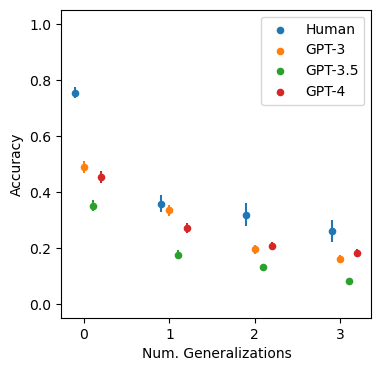

In [83]:
# Plot performance by number of generalizations

# Number of generalizations
models = ['human', '3', '35', '4']
gen_df = full_df[(full_df.prob_type!='attn')&((full_df.promptstyle=='human')|(full_df.promptstyle=='hw'))]
gen_df = gen_df.groupby(['model', 'promptstyle', 'num_gens'], as_index=False).sum()
gen_df = gen_df.drop(columns='prob_ind')

gen_df['acc'] = gen_df['correct']/gen_df['total']
gen_df['cilow'] = proportion_confint(gen_df['correct'], gen_df['total'])[0]
gen_df['ciupp'] = proportion_confint(gen_df['correct'], gen_df['total'])[1]
gen_df['yerr_low'] = gen_df['acc']-gen_df['cilow']
gen_df['yerr_upp'] = gen_df['ciupp']-gen_df['acc']

gen_df['model'] = pd.Categorical(gen_df['model'], ordered = True, categories = models)
gen_df['promptstyle'] = pd.Categorical(gen_df['promptstyle'], ordered = True, categories = promptstyles)

gen_df = gen_df.sort_values(['model', 'promptstyle', 'num_gens'])

fig, ax = plt.subplots(figsize=[4,4])


for i, model in enumerate(['human', '3', '35', '4']):
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Num. Generalizations")
    df_slice = gen_df[(gen_df['model']==model)]
    # get the accuracies
    accs = df_slice.acc
    print(f'Model: {model}')
    print(df_slice[['num_gens', 'total']])
    # get the upper and lower errors
    yerr_low = list(df_slice['yerr_low'])
    yerr_upp = list(df_slice['yerr_upp'])
    # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
    scat = ax.scatter(np.arange(len(accs)) + (i+1)*0.1, accs, s=20)
    # plot the error bars, offset by the same increment, using the same facecolors
    ax.errorbar(np.arange(len(accs)) + (i+1)*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
    # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
    ax.set_xticks(np.arange(4)+0.2)
    ax.set_xticklabels([0, 1, 2, 3])
    ax.set_ylim([-0.05, 1.05])
ax.legend(['Human','GPT-3', 'GPT-3.5', 'GPT-4'])
plt.savefig('all_gen.pdf', bbox_inches='tight')

Model: human, Num. Generalizations: 0
   nperms  total
69   np_1    276
71   np_2    336
73   np_5    270
70  np_10    342
72  np_20    384
Model: 3, Num. Generalizations: 0
  nperms  total
0   np_1    420
2   np_2    420
4   np_5    420
1  np_10    420
3  np_20    420
Model: 35, Num. Generalizations: 0
   nperms  total
21   np_1    420
23   np_2    420
25   np_5    420
22  np_10    420
24  np_20    420
Model: 4, Num. Generalizations: 0
   nperms  total
45   np_1    420
47   np_2    420
49   np_5    420
46  np_10    420
48  np_20    420
Model: human, Num. Generalizations: 1
   nperms  total
75   np_1    138
77   np_2    156
79   np_5    159
76  np_10    153
78  np_20    150
Model: 3, Num. Generalizations: 1
   nperms  total
6    np_1    420
8    np_2    420
10   np_5    420
7   np_10    420
9   np_20    420
Model: 35, Num. Generalizations: 1
   nperms  total
27   np_1    420
29   np_2    420
31   np_5    420
28  np_10    420
30  np_20    420
Model: 4, Num. Generalizations: 1
   nperms 

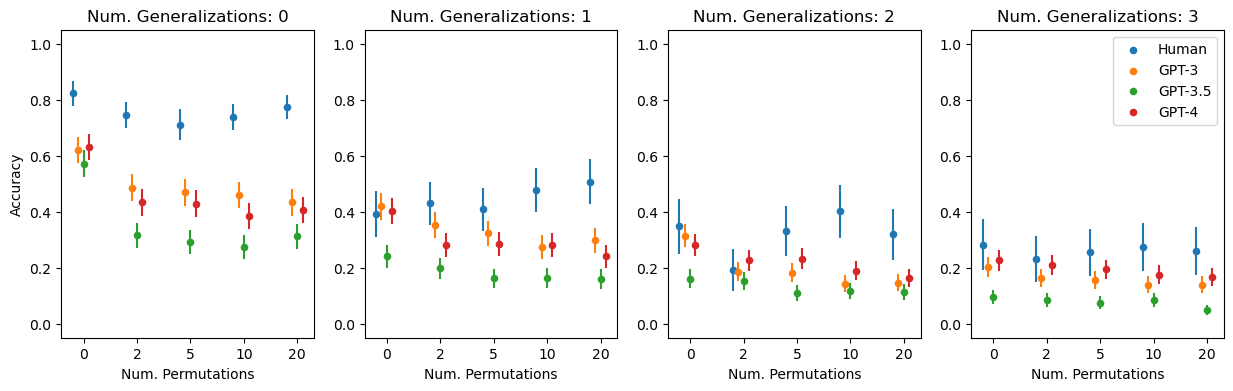

In [84]:
# Plot performance by number of generalizations and number of letters permuted

# Number of generalizations
models = ['human', '3', '35', '4']
gen_df = full_df[(full_df.prob_type!='attn')&((full_df.promptstyle=='human')|(full_df.promptstyle=='hw'))]
gen_df = gen_df.groupby(['model', 'promptstyle', 'num_gens', 'nperms'], as_index=False).sum()
gen_df = gen_df.drop(columns='prob_ind')
# print(gen_df[gen_df.model=='3']['nperms'])

gen_df['acc'] = gen_df['correct']/gen_df['total']
gen_df['cilow'] = proportion_confint(gen_df['correct'], gen_df['total'])[0]
gen_df['ciupp'] = proportion_confint(gen_df['correct'], gen_df['total'])[1]
gen_df['yerr_low'] = gen_df['acc']-gen_df['cilow']
gen_df['yerr_upp'] = gen_df['ciupp']-gen_df['acc']

gen_df['model'] = pd.Categorical(gen_df['model'], ordered = True, categories = models)
gen_df['promptstyle'] = pd.Categorical(gen_df['promptstyle'], ordered = True, categories = promptstyles)
# gen_df['prob_type'] = pd.Categorical(gen_df['prob_type'], ordered = True, categories = prob_types)
gen_df['nperms'] = pd.Categorical(gen_df['nperms'], ordered = True, categories = nperms)
gen_df = gen_df.sort_values(['model', 'promptstyle', 'num_gens', 'nperms'])
# print(gen_df.head())

perm_names = [f'Num. permuted: {n}' for n in ['None', 2, 5, 10, 20]]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

for i in range(4):
    current_slice = gen_df[gen_df.num_gens == i]
    for j, model in enumerate(['human', '3', '35', '4']):
        if i ==0:
            axs[i].set_ylabel("Accuracy")
        axs[i].set_xlabel("Num. Permutations")
        df_slice = current_slice[(current_slice['model']==model)&(current_slice['nperms']!='np_symb')]
        # get the accuracies
        accs = df_slice.acc
        print((f'Model: {model}, Num. Generalizations: {i}'))
        print(df_slice[['nperms', 'total']])
        # get the upper and lower errors
        yerr_low = list(df_slice['yerr_low'])
        yerr_upp = list(df_slice['yerr_upp'])
        # plot the accuracies on a scatter plot, each offset by a small increment (j*0.1)
        scat = axs[i].scatter(np.arange(len(accs)) + j*0.1, accs, s=20)
        # plot the error bars, offset by the same increment, using the same facecolors
        axs[i].errorbar(np.arange(len(accs)) + j*0.1, accs,  yerr=[yerr_low,yerr_upp], ls='none', color=scat.get_facecolors()[-1])
        # put the legend on the last plot 
        # put the xtick labels, offset by 0.2 to put them in the centre of each group of points
        axs[i].set_xticks(np.arange(5)+0.2)
        axs[i].set_xticklabels([0, 2, 5, 10, 20])
        axs[i].set_ylim([-0.05, 1.05])
        axs[i].set_title(f'Num. Generalizations: {i}')
axs[i].legend(['Human','GPT-3', 'GPT-3.5', 'GPT-4'])
plt.savefig('all_perm_gen.pdf', bbox_inches='tight')